In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 201277655.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31480169.91it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52619940.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9366041.68it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

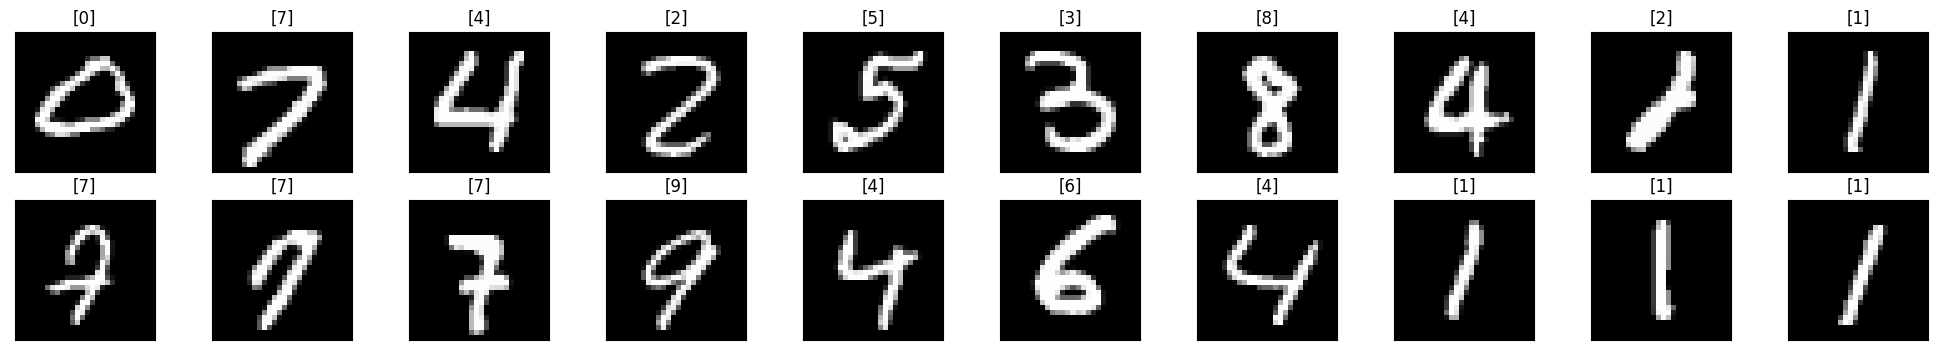

In [4]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [5]:
class Classifier(nn.Module):
  def __init__(self,input_size,hidden_size1,hidden_size2,output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size,hidden_size1)
    self.linear2 = nn.Linear(hidden_size1,hidden_size2)
    self.linear3 = nn.Linear(hidden_size2,output_size)

  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x
    

In [6]:
model = Classifier(784, 125,65,10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [8]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  ###TREINAMENTO
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
 ###VALIDACAO
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    ### TREINAMENTO
    #Cálculo da perda e acurácia média da época de treinamento:
    epoch_loss = running_loss/len(training_loader)              #Divide a soma acumulada da perda de treinamento pelo número de lotes no conjunto de treinamento 
    epoch_acc = running_corrects.float()/ len(training_loader)  #Divide a soma acumulada do número de previsões corretas pelo número total de amostras para pegar a acurácia média da época de treinamento.
    #Armazenamento das estatísticas de treinamento:
    running_loss_history.append(epoch_loss)                     #da o append na lista que registra o histórico das perdas de treinamento em cada época.
    running_corrects_history.append(epoch_acc)                  #da o append na lista que registra o histórico das acurácias de treinamento em cada época.
    
    ### VALIDACAO
    #Cálculo da perda e acurácia média da época de validação:
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    #Armazenamento das estatísticas de validação:
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    ###PRINTA OS RESULTADOS
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.4468, acc 86.9683 
validation loss: 0.2693, validation acc 91.6000 
epoch : 2
training loss: 0.2272, acc 93.2567 
validation loss: 0.1888, validation acc 94.5100 
epoch : 3
training loss: 0.1665, acc 94.9317 
validation loss: 0.1529, validation acc 95.2400 
epoch : 4
training loss: 0.1308, acc 96.0100 
validation loss: 0.1405, validation acc 95.7800 
epoch : 5
training loss: 0.1102, acc 96.5683 
validation loss: 0.1134, validation acc 96.7000 


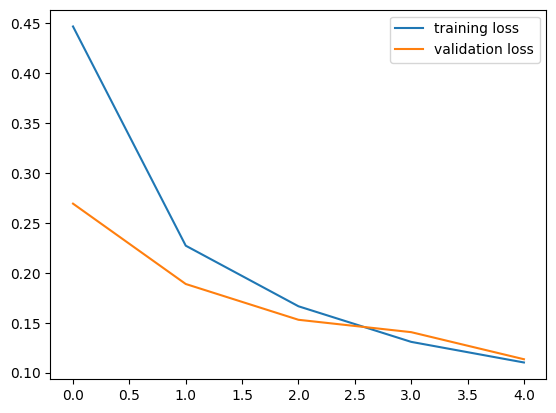

In [9]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

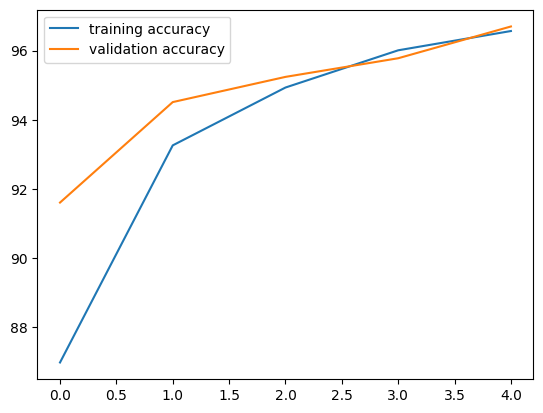

In [10]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [11]:
import PIL.ImageOps
import requests
from PIL import Image


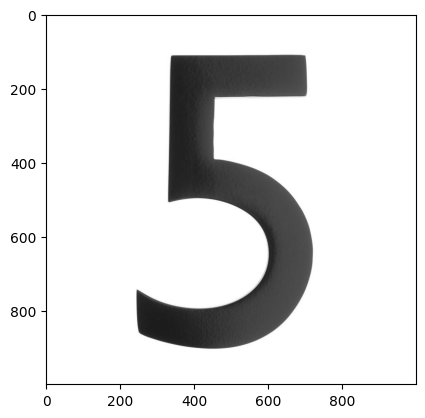

In [12]:
 
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

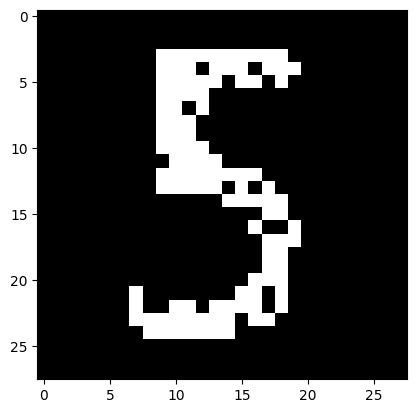

In [13]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [14]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


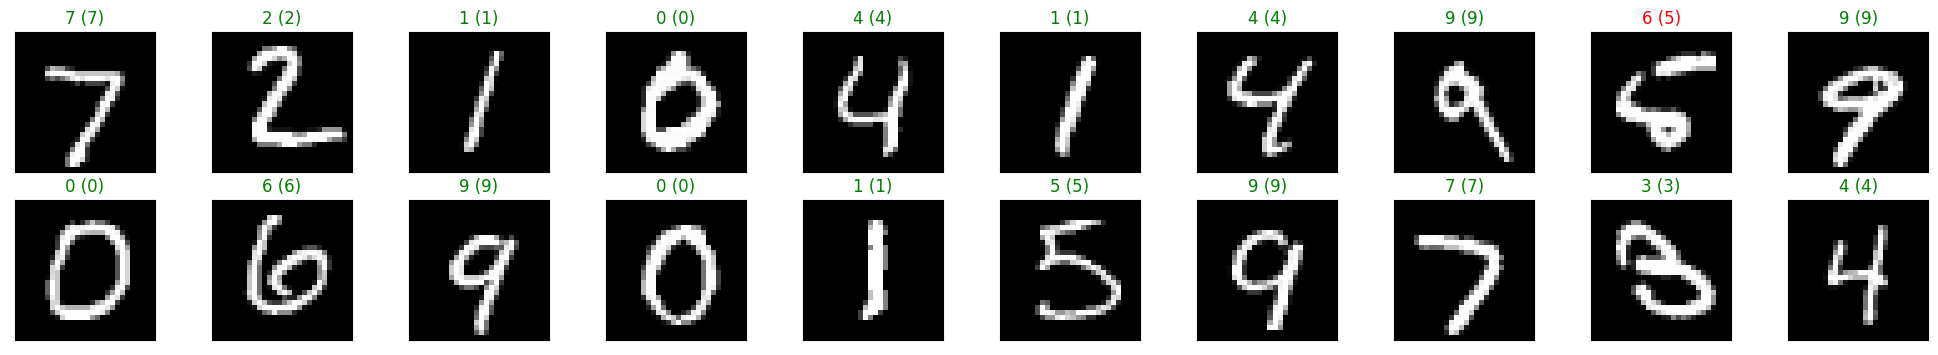

In [15]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))